# In order to get this milestone to work, the images from the Flickr-8k dataset should be placed in a directory called "Images" in the Milestone_4 directory.

In [1]:
import torch
import random
import torchvision
import os
import numpy
from xml.dom import minidom
from matplotlib import pyplot as plt
import psycopg2
import os

# Part 1, Getting a pre-trained encoder for text from Gensim

In [14]:
import gensim.downloader

glove_vectors = gensim.downloader.load('glove-twitter-200')
glove_vectors.most_similar('capitalism')

[('socialism', 0.8253527879714966),
 ('communism', 0.7220152020454407),
 ('democracy', 0.6800484657287598),
 ('capitalist', 0.6743904948234558),
 ('crony', 0.6574956774711609),
 ('fascism', 0.6154928803443909),
 ('ideology', 0.6098697185516357),
 ('imperialism', 0.6093625426292419),
 ('marxism', 0.5975797772407532),
 ('poverty', 0.5796671509742737)]

# Part 2, creating a convolutional autoencoder to encode frames

In [3]:
#An autoencoder for video frames
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.compress = torch.nn.Sequential(
            torch.nn.Conv2d(3, 3, 3, stride=2, padding=1), #Compress by 4x
            torch.nn.ReLU(False),
            torch.nn.Conv2d(3, 3, 3, stride=2, padding=1), #Compress by 4x
            torch.nn.ReLU(False),
            torch.nn.Conv2d(3, 3, 3, stride=2, padding=1), #Compress by 4x
            torch.nn.ReLU(False),
        )
        self.decompress = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(3, 3, 3, padding=1, stride=2, output_padding=1), #Decompress by 4x
            torch.nn.ReLU(False),
            torch.nn.ConvTranspose2d(3, 3, 3, padding=1, stride=2, output_padding=1), #Decompress by 4x
            torch.nn.ReLU(False),
            torch.nn.ConvTranspose2d(3, 3, 3, padding=1, stride=2, output_padding=1), #Decompress by 4x
            torch.nn.ReLU(False)
        )
         
    def forward(self, input):
        return self.decompress(self.compress(input))
    
cnn = CNN()
gpu = torch.device('cuda') 
cnn.to(gpu)


losses = []


In [ ]:
import os

adam = torch.optim.Adam(cnn.parameters(), lr=0.0001)
loss_function = torch.nn.MSELoss()


i=0
while i < 20000:
    try:
        video_index = str(random.randint(0,49))
        num_frames = len(os.listdir("../video_frames/" + video_index + "_frames/"))
        image_path = "../video_frames/" + video_index + "_frames/" + "out" + str(random.randint(1,num_frames)) + ".jpg"
        image = torchvision.io.read_image(image_path)
        image = image.float()
        image /= 256
        transform = torchvision.transforms.Resize([200, 200])
        frame = transform(image)
    except Exception as e:
        print(e)
        continue

    frame = frame.to(gpu)

    output = cnn(frame)

    loss = loss_function(output, frame)
    print(loss)
    loss.backward()

    adam.step()
    adam.zero_grad()
    i += 1
    
torch.save(cnn.state_dict(), 'cnn.pth')

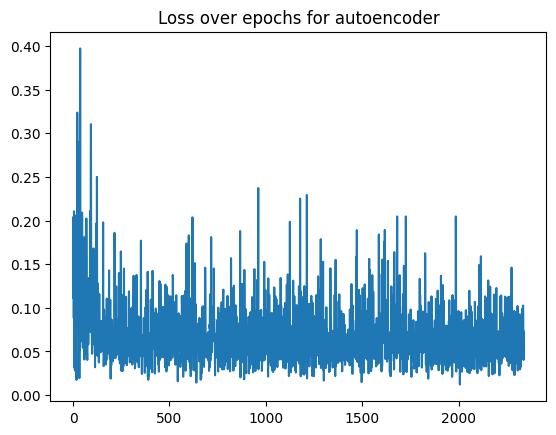

In [22]:
plt.title("Loss over epochs for autoencoder")
plt.plot([i for i in range(len(losses))], losses)
plt.show()

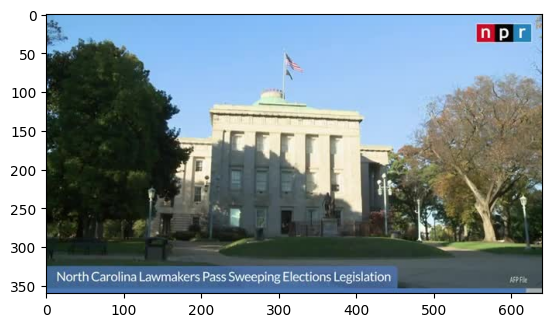

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


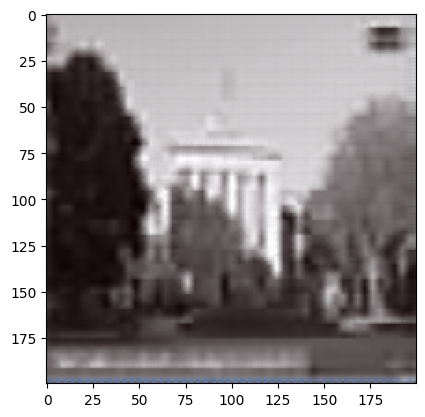

In [10]:
cnn.load_state_dict(torch.load("./cnn.pth"))

video_index = str(random.randint(0,49))
num_frames = len(os.listdir("../video_frames/" + video_index + "_frames/"))
image_path = "../video_frames/" + video_index + "_frames/" + "out" + str(random.randint(1,num_frames)) + ".jpg"
image = torchvision.io.read_image(image_path)
plt.imshow(image.permute(1,2,0))
plt.show()
image = image.float()
image /= 256
transform = torchvision.transforms.Resize([200, 200])
frame = transform(image)

frame = frame.to(gpu)

output = cnn(frame).cpu().detach()

plt.imshow(output.permute(1,2,0))
video_links = open("../video_links.txt")
video_link_lines = video_links.readlines()

# Part 3, aggregating the frames and inserting the aggregations into the database (1 entry = 1 video)

In [12]:
#Now to shove encodings into a database
conn = psycopg2.connect(
    host="localhost",
    database="datamining",
    user="msbean",
    password="cactusgreen")

conn.autocommit = True
cursor = conn.cursor() 

sql = "DELETE FROM frame_embeddings"
cursor.execute(sql) 
cnn = CNN()
cnn.load_state_dict(torch.load("./cnn.pth"))
for i in range(50):
    video_index = str(i)
    num_frames = len(os.listdir("../video_frames/" + video_index + "_frames/"))
    for frame in range(num_frames):
        image_path = "../video_frames/" + video_index + "_frames/" + "out" + str(frame+1) + ".jpg"
        image = torchvision.io.read_image(image_path)
        image = image.float()
        image /= 256
        transform = torchvision.transforms.Resize([200, 200])
        frame = transform(image)


        output = cnn.compress(frame)

        sql = "INSERT INTO frame_embeddings (embedding, youtube_link) VALUES ('["
        flattened = output.flatten().tolist()
        for datum in flattened:
            sql += str(datum) + ","
        sql = sql[:-1]
        sql += "]',"
        sql += "'" + video_link_lines[i] + "'"
        sql += ")"
        cursor.execute(sql) 

conn.commit() 
conn.close()

# Part 4, Text indexing (using DOM traversal)

In [15]:
nones = 0
somes = 0
text_embeddings = [[] for i in range(50)]

for v in range(50):
    dom = minidom.parse("../videos/" + str(v) + "_captions.txt")
    for caption in dom.getElementsByTagName("s"):
        for child_node in caption.childNodes:
            if child_node.nodeType == child_node.TEXT_NODE:
                stripped = ''.join([i for i in child_node.data if i.isalpha()]).lower()
                if stripped in glove_vectors:
                    embedding = glove_vectors[stripped]
                    text_embeddings[v].append(embedding)

                    somes += 1
                else:
                    nones += 1
print(somes / (somes + nones))


0.9795010714430114


# Part 5, contrastive loss based on the SimCLR article

In [16]:
import math
class CNN2(torch.nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        #These will project the image and text encodings to be 1875-dimensional vectors
        #So that we can take the dot product between image and text encodings
        self.project_image = torch.nn.Sequential(
            torch.nn.Flatten(1, -1),
            torch.nn.Linear(1875, 1875),
            torch.nn.ReLU(),
            torch.nn.Linear(1875, 1875),
            torch.nn.ReLU(),
            torch.nn.Linear(1875, 1875)
        )
        self.project_text = torch.nn.Sequential(
            torch.nn.Linear(200, 1875),
            torch.nn.ReLU(),
            torch.nn.Linear(1875, 1875),
            torch.nn.ReLU(),
            torch.nn.Linear(1875, 1875)
        )
         
    def forward(self, word_encodings, image_encodings):
        word_encodings = self.project_text(word_encodings)
        word_encodings = torch.nn.functional.normalize(word_encodings)
        image_encodings = self.project_image(image_encodings)
        image_encodings = torch.nn.functional.normalize(image_encodings)
        return word_encodings, image_encodings
    
cnn2 = CNN2()
cnn2.to(gpu)
cnn2.load_state_dict(torch.load("./cnn2.pth"))
training_losses = []

    

In [17]:
adam = torch.optim.Adam(cnn2.parameters(), lr=0.000001)
transform = torchvision.transforms.Resize([200, 200])

conn = psycopg2.connect(
    host="localhost",
    database="datamining",
    user="msbean",
    password="cactusgreen")

conn.autocommit = True
cursor = conn.cursor() 

# This approach is not based on the tensorflow implementation we were given. It did not work. 
# This is based on the pirated SimCLR article we were given, which does not show an implementation.
# I have had some degree of success with this approach. The video results do seem relevant to the queries
# when using it in the app.

for i in range(8000):
    sql = "SELECT youtube_link, AVG(embedding) AS embedding FROM frame_embeddings GROUP BY youtube_link ORDER BY RANDOM () LIMIT 10"
    cursor.execute(sql)
    results = cursor.fetchall()

    frame_embeddings = []
    word_embeddings = []
    for result in results:
        video_index = video_link_lines.index(result[0])
        word_embedding = text_embeddings[video_index]
        word_embedding = numpy.mean(word_embedding, axis=0)
        frame_embedding = [float(s) for s in result[1][1:-1].split(",")]

        frame_embeddings.append(torch.FloatTensor(frame_embedding))
        word_embeddings.append(torch.FloatTensor(word_embedding))

    frame_embeddings = torch.stack(frame_embeddings)
    frame_embeddings = frame_embeddings.to(gpu)

    word_embeddings = torch.stack(word_embeddings)
    word_embeddings = word_embeddings.to(gpu)

    word_embeddings, frame_embeddings = cnn2.forward(word_embeddings, frame_embeddings)
    cosine_similarities = torch.matmul(frame_embeddings, torch.transpose(word_embeddings, -1, 0))
    cosine_similarities = torch.e**cosine_similarities
    diagonal = torch.diagonal(cosine_similarities)
    cosine_similarities_sum = cosine_similarities.sum(dim=1)

    similarities = diagonal/cosine_similarities_sum
    errors = -torch.log(similarities)

    errors.sum().backward()
    
    adam.step()
    adam.zero_grad()


    training_losses.append(errors.sum().item())


conn.commit() 
conn.close()

In [18]:
torch.save(cnn2.state_dict(), 'cnn2.pth')

In [20]:
import psycopg2
import os
conn = psycopg2.connect(
    host="localhost",
    database="datamining",
    user="msbean",
    password="cactusgreen")

conn.autocommit = True
cursor = conn.cursor() 
sql = "DELETE FROM projected_video_embeddings"
cursor.execute(sql)
sql = "SELECT youtube_link, AVG(embedding) AS embedding FROM frame_embeddings GROUP BY youtube_link"
cursor.execute(sql)
results = cursor.fetchall()

for result in results:
    frame_embeddings = []
    word_embeddings = []
    video_index = video_link_lines.index(result[0])
    word_embedding = random.sample(text_embeddings[video_index], 50)
    word_embedding = numpy.mean(word_embedding, axis=0)
    frame_embedding = [float(s) for s in result[1][1:-1].split(",")]

    frame_embeddings.append(torch.FloatTensor(frame_embedding))
    word_embeddings.append(torch.FloatTensor(word_embedding))


    frame_embeddings = torch.stack(frame_embeddings)
    frame_embeddings = frame_embeddings.to(gpu)

    word_embeddings = torch.stack(word_embeddings)
    word_embeddings = word_embeddings.to(gpu)

    word_embeddings, frame_embeddings = cnn2.forward(word_embeddings, frame_embeddings)
    sql = "INSERT INTO projected_video_embeddings (embedding, youtube_link) VALUES ('["
    flattened = frame_embeddings.flatten().tolist()
    for datum in flattened:
        sql += str(datum) + ","
    sql = sql[:-1]
    sql += "]',"
    sql += "'" + str(video_index) + ".mp4'"
    sql += ")"
    cursor.execute(sql) 
conn.commit() 
conn.close()

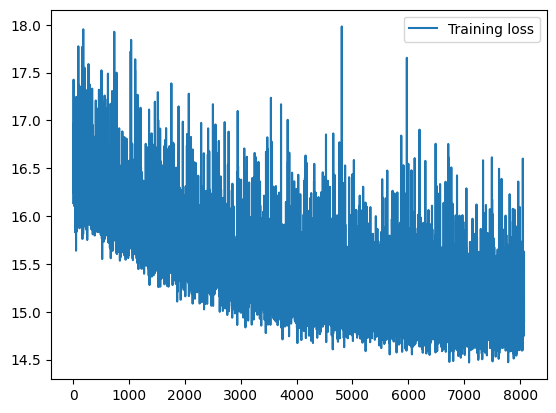

In [ ]:
from matplotlib import pyplot as plt

plt.plot([i for i in range(len(training_losses))], training_losses, label="Training loss for dual encoder")
plt.legend()

plt.show()

# Now for the final result, getting 3 videos based on a text query.

In [22]:
import numpy

def encode_caption_string(caption_string):
    encodings = []
    for caption in caption_string:
        if caption in glove_vectors:
            encodings.append(glove_vectors[caption])
    if len(encodings) == 0:
        return None
    return numpy.mean(encodings, axis=0)



conn = psycopg2.connect(
    host="localhost",
    database="datamining",
    user="msbean",
    password="cactusgreen")

conn.autocommit = True
cursor = conn.cursor() 

encoding = torch.stack([torch.FloatTensor(encode_caption_string("gaza israel".split(" ")))])
encoding = encoding.to(gpu)
encoding = cnn2.project_text(encoding)

sql = "SELECT youtube_link FROM projected_video_embeddings ORDER BY embedding <-> '["
flattened = encoding.flatten().tolist()
for datum in flattened:
    sql += str(datum) + ","
sql = sql[:-1]
sql += "]' LIMIT 3"

cursor.execute(sql)
result = cursor.fetchall()
print(result)

conn.commit() 
conn.close()

[('3.mp4',), ('1.mp4',), ('2.mp4',)]
